## abstract
- Goal of this notebook was to develop a programm that given a target sequence, can find subsequences of a given length that are as unique compared to reference sequences as possible
- Currently the script does exactly that, but no more
- Next goals
    - overhaul variable and function naming
    - show transcript annotation at the end for the unavoidable off-target interactions
    - integrate transcript count datasets to weight off-target effects
    - integrate better probability prediction model
    - keep sequences and annotations together: consider custom classes, or redo the main code to handle pandas.DataFrame and pandas.Series objects. Maybe tracking sequence IDs consistently might already be enough.

In [1]:
from multiprocessing import Pool
from tqdm import tqdm
import pandas as pd
from time import time
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [2]:
def ensemble_fasta_to_dict(fasta_entry):
    data = {}
    m1 = fasta_entry.find(" ")
    m2 = fasta_entry.find(" ", m1+1)
    
    data["TRANSCRIPT_ID"]      = fasta_entry[   1:m1]
    data["SEQTYPE"]            = fasta_entry[m1+1:m2]
    
    m3 = fasta_entry.find(" chromosome:",         m2+1)
    m4 = fasta_entry.find(" gene:",               m3+1)
    m5 = fasta_entry.find(" gene_biotype:",       m4+1)
    m6 = fasta_entry.find(" transcript_biotype:", m5+1)
    m7 = fasta_entry.find(" description:",        m6+1)
    m8 = fasta_entry.find(" [Source:",            m7+1)
    m9 = fasta_entry.find("]",                    m8+1)
    
    data['LOCATION']             = fasta_entry[m3+12:m4]
    data['GENE_ID']              = fasta_entry[m4+6 :m5]
    data['GENE_BIOTYPE']         = fasta_entry[m5+14:m6]
    data['TRANSCRIPT_BIOTYPE']   = fasta_entry[m6+20:m7]
    data['DESCRIPTION']          = fasta_entry[m7+13:m8]
    data['SEQUENCE']             = fasta_entry[m9+1:]
    
    return data

def read_ensemble_fasta(file_path, timeit=True):
    if timeit: s = time()
    df = pd.DataFrame(columns = ['TRANSCRIPT_ID', 'SEQTYPE', 'LOCATION', 'GENE_ID', 'GENE_BIOTYPE', 'TRANSCRIPT_BIOTYPE', 'DESCRIPTION', 'SEQUENCE'])
    buffer = ""
    i = 0
    with open(file_path) as file:
        buffer = ""
        for line in file:
            i += 1
            buffer += line.rstrip()
            z = buffer.rfind(">")
            if z>0:
                entry = buffer[:z].replace("\n", "")
                buffer = buffer[z:]
                df = pd.concat([df, pd.DataFrame([ensemble_fasta_to_dict(entry)])], ignore_index=True)
                
    if timeit: print(f"{time()-s:.2g}s")
    return df


@njit
def sc_jit(ref, seq):
    '''A fast sequence comparison of a short sequence against a larger reference.
    Returns the number of matches for every position the sort sequence could bind to the larger one. Consideres only full overlap binding, i.e. no overhangs '''

    n = len(ref) - len(seq) + 1
    cv = np.zeros(n, dtype=np.int8) 
    for i in range(n):
        count = 0
        for j in range(len(seq)):
            if ref[i + j] == seq[j]:
                count += 1
        cv[i] = count
    return cv
    
    
sc_jit(np.random.randint(0, 3, 100), np.random.randint(0, 3, 10));    # call it once for numba to compile the function

def search_target_in_refpool(target, reference_pool, plot = False):
    '''searches for (partial) matches between target and reference pool
    target: sequence to be found
    reference pool: list/array of sequences to test against'''
    
    #------------------------------------------#
    #  Search binding sites in all transcripts #
    #------------------------------------------#
    
    sequence_compare_results = pd.DataFrame()                  # initialize a dataset to store the results of every transcript in the transcriptome
    for i, ref in enumerate(reference_pool):                   # iterate over all reference sequences. 
        
        mm = len(target)-sc_jit(ref, target)                   # search target in reference sequence and count number of mismatches for every possible position
        sc_row = {}                                            # summarize the interaction of the tested binding site against the transcript from the transcriptome
        sc_row["MissMatch_eq_0"] = (mm==0).sum()               # number of idential matches
        sc_row["MissMatch_eq_1"] = (mm==1).sum()               # number of matches with 1 mismatch
        sc_row["MissMatch_eq_2"] = (mm==2).sum()               # number of matches with 2 mistmatches
        sc_row["BoltzmanFactor"] = np.sum(np.exp(-mm))         # a prediction of how likely the BSC would bind to this transcript. Currently the BoltzmanFactor for a perfect match is 1, if therefore this predicted BoltzmanFactor is smaller than 1 than it is more likly to bind to the specific RNA, while if it is larger than one it is more likely to bind to the background transcriptom ""
        
        sequence_compare_results = pd.concat([sequence_compare_results, pd.DataFrame([sc_row])], ignore_index=True) # add the results for this transcript to the dataset

    #---------------------------------#
    # summarize results of the search #       # now that we have a huge and detailed list of the interaction with every of the thousands of transcripts, we need to summarize again to only a few metrics.
    #---------------------------------#
    
    scr = sequence_compare_results 
    metrics = [scr.MissMatch_eq_0, scr.MissMatch_eq_1, scr.MissMatch_eq_2, scr.BoltzmanFactor]
    display_names = {"MissMatch_eq_0" : "identical match offsite-targets", "MissMatch_eq_1" : "1-missmatch offsite-targets", "MissMatch_eq_2" : "2-missmatch offsite-targets", "BoltzmanFactor" : "pseudo non-normalized binding probability prediction"}  # important for the labels during plotting
    candidate_summary = {"sequence": target}
    if plot: fig, ax = plt.subplots(len(metrics), 2, figsize = (12, 8), gridspec_kw={'width_ratios': [1, 5]}, dpi = 180)
        
    for i, metric in enumerate(metrics): # iterate over all the metrics that should be summarized
        e = 100
        candidate_summary[metric.name+f"_max"] = metric.max()  # What was the highest number of off-target binding sites on a single transcript 
        candidate_summary[metric.name+f"_sum"] = metric.sum()  # What was the total number of off-target binding sites on the whole transcriptome
        candidate_summary[metric.name+f"_score{e}"] = np.emath.logn(e, np.sum(e**(metric/e))) - 1.5 # something inbetween max and sum, its a weighted sum where 100 trancripts with one binding site are worth as much as one transcript with two binding sites.  This penelizes outliers with a high number of binding sites on a single transcript, while still containing the information of all other transcripts as well. The e = 100 was chosen arbitrarily, there likly is a better way of weighting all this
        insert = "" # for plotting labels
        if plot:
            if metric.max() > 0 and i < 3: # i.e. if there are mismatches to plot. i==3 is pseudo prob and metric.max() <= 0 is no mismatches
                insert = f"  »  {(metric == metric.max()).sum()} transcripts with {metric.max()} off-target binding sites"
                ax[i,0].hist(metric, log = True, range = (0.5, metric.max()+0.5), bins = np.ceil(metric.max()).astype(int), orientation='horizontal', rwidth = .8) # ignore the 0 mismatch per transcript bin, it might be to large
                if  metric.max() == 1: # with at most one mistmatch per transcript, the histogram has only one bar
                    ax[i,0].set_yticks([1])
            elif i==3:
                ax[i,0].hist(metric, log = True, orientation='horizontal', rwidth = .8) # plot predicted binding pseudo probability (not normalized, i.e. arbitrary units)
            else:
                ax[i,0].set_yticks([0])
                
            ax[i,1].fill_between(np.arange(len(metric)), np.zeros(len(metric)), metric, ec = "tab:blue", fc = "tab:blue", lw = 0.2, alpha = 1)
            ax[i,0].set_xlabel("number of transcripts")
            ax[i,0].set_ylabel("number of\n off-target binding sites")
            ax[i,1].set_xlabel("transcript ID")
            ax[i,1].set_xlim(-len(metric)*0.005, len(metric)*1.005)
            ax[i,1].set_title(display_names[metric.name] + insert)
            ax[i,1].set_yticks([])
            plt.tight_layout()
    
    return candidate_summary


### Load transcriptome data

In [3]:
ncrna = read_ensemble_fasta("sequence_data/Saccharomyces_cerevisiae.R64-1-1.ncrna.fa")
cdna = read_ensemble_fasta("sequence_data/Saccharomyces_cerevisiae.R64-1-1.cdna.all.fa")
transcriptom = pd.concat([cdna, ncrna], ignore_index=True)
transcriptom

0.13s
2.4s


,TRANSCRIPT_ID,SEQTYPE,LOCATION,GENE_ID,GENE_BIOTYPE,TRANSCRIPT_BIOTYPE,DESCRIPTION,SEQUENCE
0,YPL071C_mRNA,cdna,NA cdna chromosome:R64-1-1:XVI:420048:420518:-1,YPL071C,protein_coding,protein_coding,Putative protein of unknown function; green fl...,ATGAGTTCCCGGTTTGCAAGAAGTAATGGCAATCCCAACCACATTA...
1,YLL050C_mRNA,cdna,NA cdna chromosome:R64-1-1:XII:39804:40414:-1,YLL050C,protein_coding,protein_coding gene_symbol:COF1,"Cofilin, involved in pH-dependent actin filame...",ATGTCTAGATCTGGTGTTGCTGTTGCTGATGAATCCCTTACCGCTT...
2,YMR172W_mRNA,cdna,NA cdna chromosome:R64-1-1:XIII:605981:608140:1,YMR172W,protein_coding,protein_coding gene_symbol:HOT1,Transcription factor for glycerol biosynthetic...,ATGTCTGGAATGGGTATTGCGATTCTTTGCATCGTACGTACAAAGA...
3,YOR185C_mRNA,cdna,NA cdna chromosome:R64-1-1:XV:681444:682106:-1,YOR185C,protein_coding,protein_coding gene_symbol:GSP2,GTP binding protein (mammalian Ranp homolog); ...,ATGTCAGCACCTGCTCAAAACAATGCCGAGGTTCCCACTTTCAAGT...
4,YLL032C_mRNA,cdna,NA cdna chromosome:R64-1-1:XII:74270:76747:-1,YLL032C,protein_coding,protein_coding,Protein of unknown function; may interact with...,ATGGATAACTTCAAAATTTACAGTACAGTTATCACAACTGCTTTTT...
...,...,...,...,...,...,...,...,...
7029,tI(AAU)E2_tRNA,ncrna,tRNA ncrna chromosome:R64-1-1:V:551285:551358:-1,tI(AAU)E2,tRNA,tRNA,"Isoleucine tRNA (tRNA-Ile), predicted by tRNAs...",GGTCTCTTGGCCCAGTTGGTTAAGGCACCGTGCTAATAACGCGGGG...
7030,tS(GCU)O_tRNA,ncrna,RNA ncrna chromosome:R64-1-1:XV:274673:274773:1,tS(GCU)O,tRNA,tRNA,"Serine tRNA (tRNA-Ser), predicted by tRNAscan-...",GTCCCAGTGGCCGAGTGGTTAAGGCGATGCCCTGCTAAGGCATTGG...
7031,tY(GUA)F1_tRNA,ncrna,tRNA ncrna chromosome:R64-1-1:VI:167437:167525:1,tY(GUA)F1,tRNA,tRNA gene_symbol:SUP11,"Tyrosine tRNA (tRNA-Tyr), predicted by tRNAsca...",CTCTCGGTAGCCAAGTTGGTTTAAGGCGCAAGACTGTAAATCTTGA...
7032,tG(UCC)O_tRNA,ncrna,RNA ncrna chromosome:R64-1-1:XV:110962:111033:-1,tG(UCC)O,tRNA,tRNA gene_symbol:SUF1,"Glycine tRNA (tRNA-Gly), predicted by tRNAscan...",GGGCGGTTAGTGTAGTGGTTATCATCCCACCCTTCCAAGGTGGGGA...


In [4]:
len(transcriptom.SEQUENCE.sum()), len(transcriptom), len(transcriptom.SEQUENCE.sum())/len(transcriptom)

(8855347, 7034, 1258.9347455217514)

### Load mCherry sequencing data

In [13]:
with open("sequence_data/iGEM_mCherry_V2.fasta") as file: content = [line for line in file]
target = {"NAME": content[0][1:].rstrip(), "SEQUENCE": content[1].upper()}
target

{'NAME': 'iGEM_mCherry_BBa_E2060',
 'SEQUENCE': 'ATGGCAACTAGCGGCATGGTTAGTAAAGGAGAAGAAAATAACATGGCAATCATTAAGGAGTTCATGAGATTCAAAGTTCACATGGAAGGTTCTGTAAATGGACATGAATTTGAAATAGAAGGTGAAGGAGAAGGAAGGCCTTATGAAGGAACCCAAACCGCGAAGCTAAAAGTTACTAAGGGTGGCCCATTACCATTTGCATGGGATATCCTTAGCCCTCAATTCATGTATGGGTCAAAGGCTTATGTCAAGCACCCCGCCGACATTCCAGACTATCTAAAGTTATCTTTTCCCGAAGGGTTTAAGTGGGAGCGTGTGATGAACTTCGAAGACGGTGGCGTGGTAACAGTGACTCAGGATTCGTCCCTGCAAGATGGTGAATTTATCTACAAAGTCAAATTAAGAGGAACTAACTTTCCATCTGACGGCCCGGTTATGCAAAAAAAGACAATGGGCTGGGAGGCCTCCTCAGAACGAATGTACCCTGAAGATGGTGCCTTGAAGGGTGAGATTAAACAAAGATTGAAATTGAAAGATGGTGGACATTATGACGCTGAGGTTAAAACGACATACAAAGCTAAGAAACCTGTCCAGCTCCCAGGTGCTTACAATGTAAATATAAAACTTGATATTACATCACATAATGAAGATTATACGATAGTTGAACAATACGAAAGGGCTGAGGGGAGACATAGTACTGGTGGCATGGATGAACTATACAAAGGTTCTGGTACCGCATAATAACACTGATAGTGCTAGTGTAGATCAC'}

### Parallel processing: Multiprocessing.Pool 


In [14]:
target_seq = target["SEQUENCE"].encode("utf-8")
binding_site_len = 12

candidates = [target_seq[k:k+binding_site_len] for k in range(len(target_seq)-binding_site_len)] 
transcript_sequences = [seq.encode("utf-8") for seq in transcriptom.SEQUENCE]

In [15]:

def _worker(candidate):
    return search_target_in_refpool(candidate, transcript_sequences)
    
with Pool(16) as pool: 
    scores = list(tqdm(pool.imap(_worker, candidates), total=len(candidates), ncols = 100))


100%|█████████████████████████████████████████████████████████████| 757/757 [04:39<00:00,  2.70it/s]


In [16]:
df = pd.DataFrame(scores)
df

/home/l3x/.miniforge3/envs/F1/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,sequence,MissMatch_eq_0_max,MissMatch_eq_0_sum,MissMatch_eq_0_score100,MissMatch_eq_1_max,MissMatch_eq_1_sum,MissMatch_eq_1_score100,MissMatch_eq_2_max,MissMatch_eq_2_sum,MissMatch_eq_2_score100,BoltzmanFactor_max,BoltzmanFactor_sum,BoltzmanFactor_score100
0,b'ATGGCAACTAGC',0,0,0.423601,1,19,0.423629,2,264,0.423985,6.789062,4040.0,0.428878
1,b'TGGCAACTAGCG',0,0,0.423601,1,5,0.423608,2,171,0.423850,5.609375,3456.0,0.428878
2,b'GGCAACTAGCGG',0,0,0.423601,1,2,0.423604,3,136,0.423799,5.035156,3132.0,0.428878
3,b'GCAACTAGCGGC',0,0,0.423601,1,9,0.423614,2,150,0.423819,4.960938,3122.0,0.428878
4,b'CAACTAGCGGCA',1,1,0.423603,1,16,0.423624,3,201,0.423894,5.773438,3636.0,0.428878
...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,b'GTGCTAGTGTAG',0,0,0.423601,1,15,0.423623,2,181,0.423865,5.929688,3672.0,0.428878
753,b'TGCTAGTGTAGA',1,1,0.423603,1,22,0.423633,3,360,0.424126,7.742188,4380.0,0.430575
754,b'GCTAGTGTAGAT',1,1,0.423603,1,21,0.423632,2,323,0.424072,7.683594,4288.0,0.430575
755,b'CTAGTGTAGATC',1,1,0.423603,1,17,0.423626,2,192,0.423881,6.976562,4002.0,0.428878


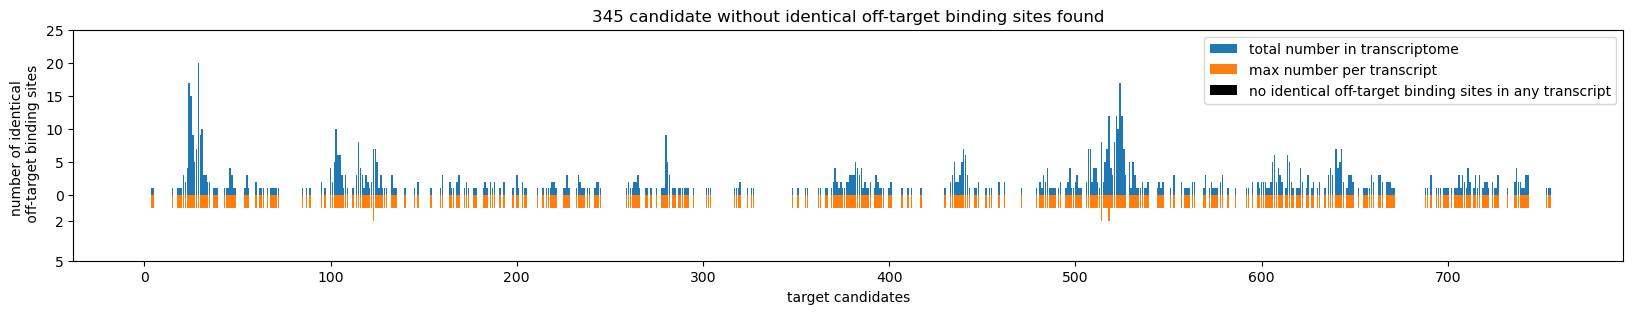

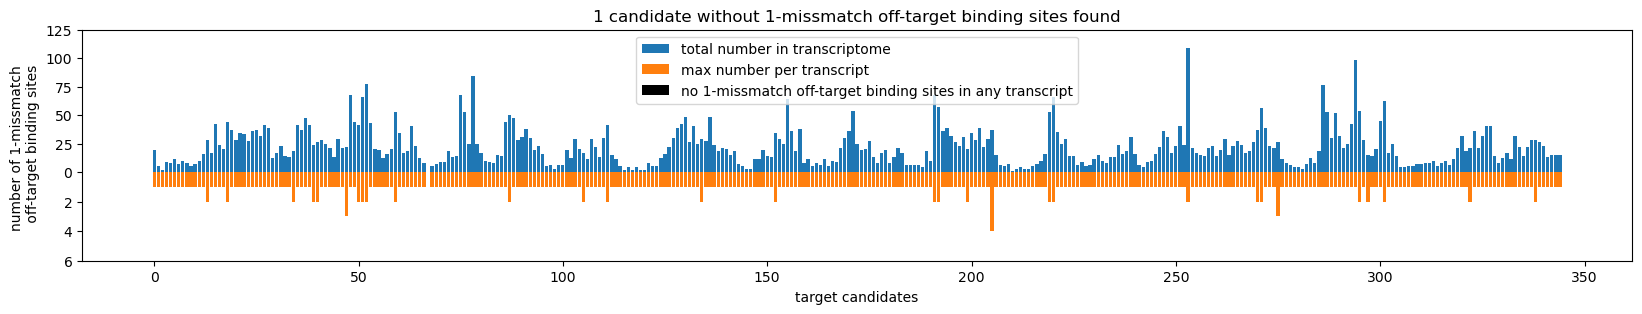

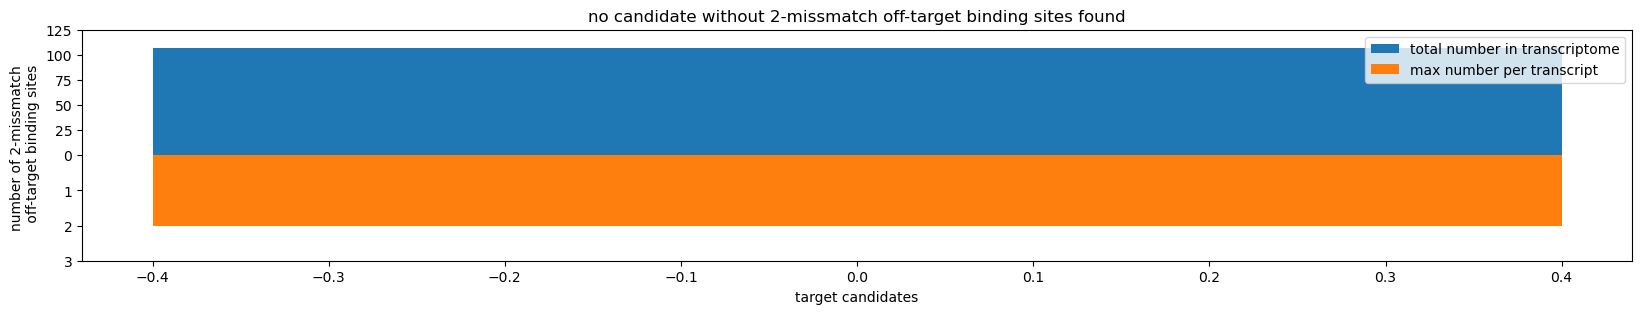

continue with 1 candidates


In [17]:

## Visualize the the offtarget binding sites for every candidate sequence ## 

df = pd.DataFrame(scores)
col = f'MissMatch_eq'
for _mm in range(0, 3):

    col1 = col + f'_{_mm}_sum'
    col2 = col + f'_{_mm}_max'
    sel = df[df[col1]<0.5]
    plt.figure(figsize = (20, 3))

    if _mm == 0: insert = "identical"
    else:        insert = f"{_mm}-missmatch"

    sx = np.round(0.66 * df[col1].mean() / df[col2].mean(), 0).astype(int)
    plt.bar(df.index,  df[col1].values, label = "total number in transcriptome")
    plt.bar(df.index, -df[col2].values*sx,  label = "max number per transcript")
    if len(sel) > 0:
        plt.bar(sel.index, .02*df[col2].max(), bottom = -.01*df[col2].max(), label = f"no {insert} off-target binding sites in any transcript", color = "black")
    plt.xlabel("target candidates")
    plt.ylabel(f"number of {insert} \n off-target binding sites");
    yl = plt.yticks()[0]
    yl[yl<0] /= sx
    yl = np.unique(yl.round().astype(int))
    yt = yl.copy()
    yt[yt<0] *= sx
    plt.yticks(yt, np.abs(yl))
    plt.legend();

    if len(sel) == 0:
        plt.title(f"no candidate without {insert} off-target binding sites found")
        plt.show()

    else: 
        df = sel.reset_index(drop = _mm > 0)  # select only those with fewest number of offtarget binding sites
        plt.title(f"{len(sel)} candidate without {insert} off-target binding sites found")
    plt.show()
select = df.copy()
print(f"continue with {len(select)} candidates")

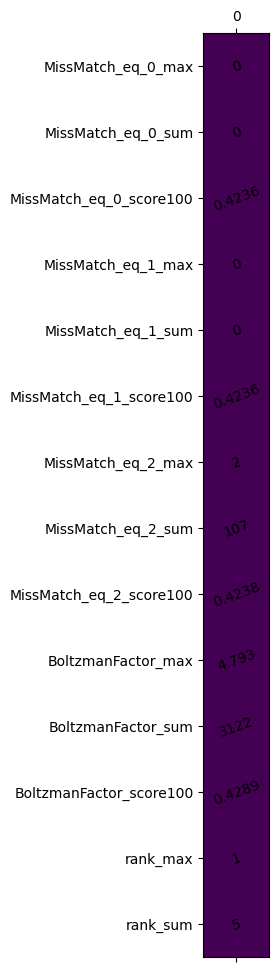


----------------------------------------------------------------------------------------------------
index                                  150
sequence                   b'ACCCAAACCGCG'
MissMatch_eq_0_max                       0
MissMatch_eq_0_sum                       0
MissMatch_eq_0_score100           0.423601
MissMatch_eq_1_max                       0
MissMatch_eq_1_sum                       0
MissMatch_eq_1_score100           0.423601
MissMatch_eq_2_max                       2
MissMatch_eq_2_sum                     107
MissMatch_eq_2_score100           0.423757
BoltzmanFactor_max                4.792969
BoltzmanFactor_sum                  3122.0
BoltzmanFactor_score100           0.428878
rank_max                               1.0
rank_sum                               5.0
Name: 0, dtype: object


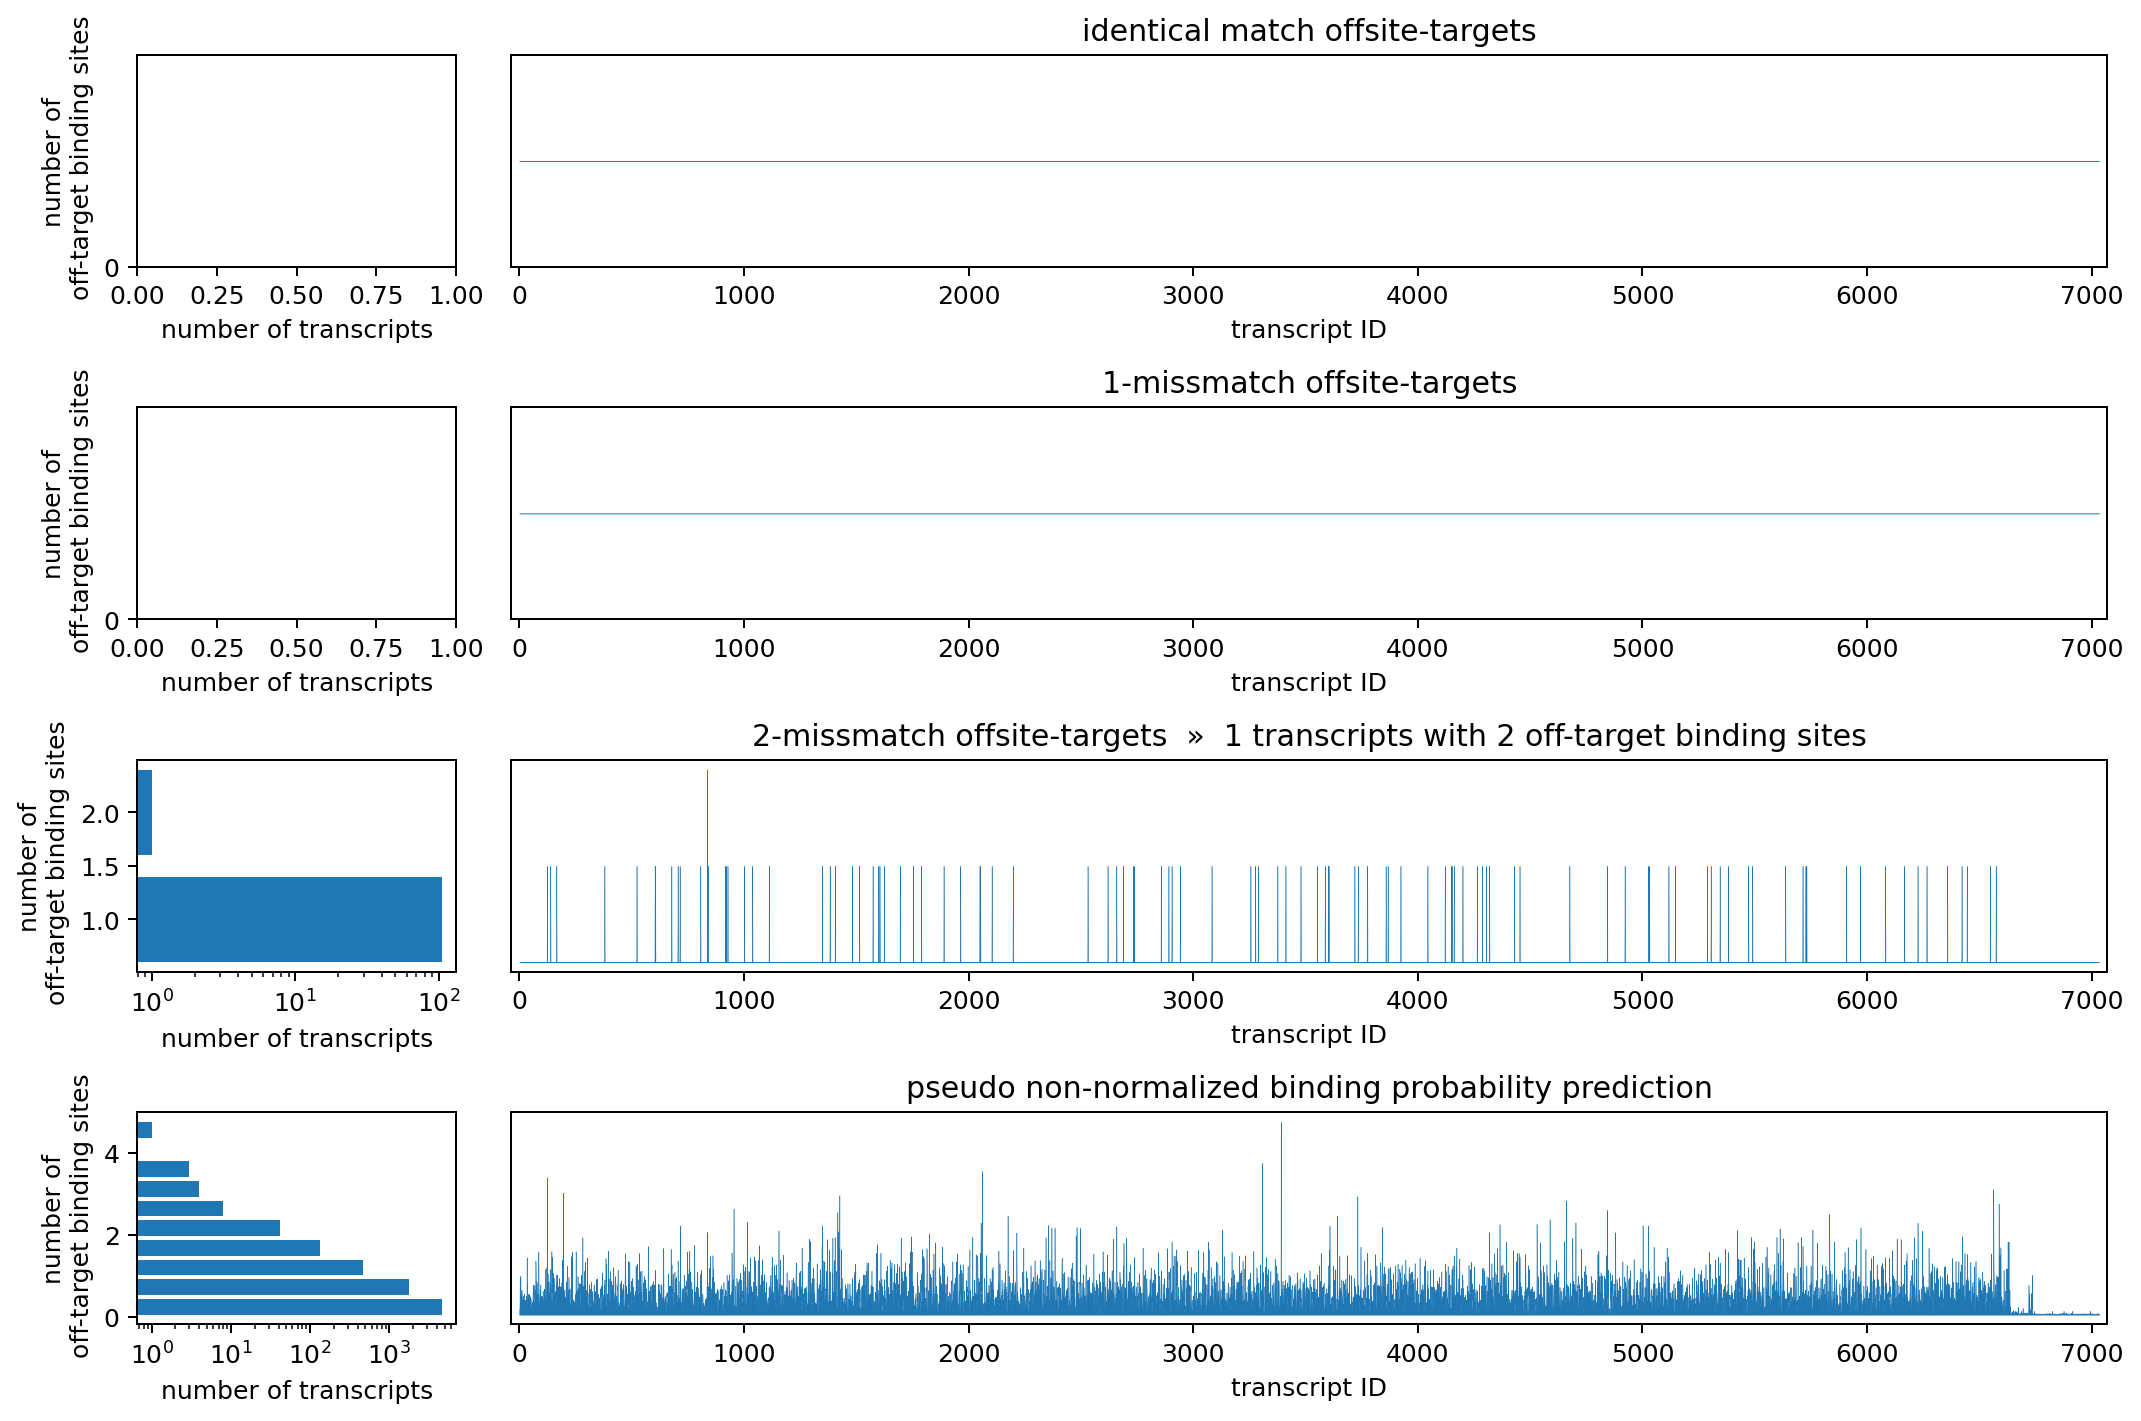

In [18]:
## Rank remaining sequences based on obtained metrics

select["rank_max"] = 0
select["rank_sum"] = 0
for col in ['MissMatch_eq_0_score100', 'MissMatch_eq_1_score100', 'BoltzmanFactor_score100', 'BoltzmanFactor_max', 'BoltzmanFactor_sum']:
    select["rank_max"] = np.max([select[col].rank(pct = True), select["rank_max"]], axis = 0)
    select["rank_sum"] += select[col].rank(pct = True)
candidates = pd.concat([select.sort_values("rank_max")[:5], select.sort_values("rank_sum")[:5]]).sort_values("BoltzmanFactor_max")
candidates = candidates[~candidates.index.duplicated(keep='first')]

_df = candidates.drop(["sequence", "index"], axis = 1)
mat = np.array(_df.values)
mat -= mat.mean(axis = 0)
mat /= (mat.std(axis = 0)+1e-9)
mat += 2*(mat.std(axis = 0)+1e-9)

fig = plt.figure(figsize = (8, 12))
plt.matshow(mat.T, fignum = 0)

for (i, j), z in np.ndenumerate(np.array(_df.values)):
    plt.text(i,j, '{:0.4g}'.format(z), ha='center', va='center', rotation = 20, fontsize = 10)

plt.yticks(np.arange(0, mat.shape[1]), labels = _df.columns);
plt.xticks(np.arange(0, mat.shape[0]), labels = _df.index);
plt.show()

for i, row in candidates.iterrows():
    print("\n" + "-"*100)
    print(row)
    search_target_in_refpool(row["sequence"], transcript_sequences, plot = True)
    plt.show()